## Before starting: select "dtw" kernel

- In the menu bar on top of this notebook, select Kernel > Change Kernel > "dtw"

- In the top right corner, there should be the Python logo and "dtw" should be written next to the circle monitoring kernel activity.


# (Step2) Align two sequences with `sm-dtw`

*In step1*, you previously produced a pair of phyllotaxis sequences: one reference sequence and a test sequence which derives from the first after typical "measurement errors". Each phyllotaxis sequence is made of two sub-sequences: the divergence angles and the internode lengths between successive organs along a stem.

Here, you will use our program `sm-dtw` to realign the test sequence with the reference and detect automatically the potential additions or losses of organs along the test sequence.


## 1. Upload simulated sequences generated in step1

In [44]:
import numpy as np
import pandas as pd

from dtw import DTW
from dtw.metrics import angular_dist
from dtw.metrics import euclidean_dist
from dtw.metrics import mixed_dist
from dtw.tasks.search_free_ends import brute_force_free_ends_search

In [45]:
ref_df = pd.read_csv("/myapp/docker_sandbox/reference_sequences.csv")
test_df = pd.read_csv("/myapp/docker_sandbox/test_sequences.csv")

In [46]:
# have a look at the table
# check out the PlantID: there should be only one after step1 notebook, default is "MyPlant"
ref_df
# test_df

,PlantID,angles,Internodes
0,MyPlant,158,57
1,MyPlant,127,28
2,MyPlant,115,17
3,MyPlant,124,15
4,MyPlant,153,6
5,MyPlant,166,7
6,MyPlant,152,4
7,MyPlant,143,5
8,MyPlant,129,6
9,MyPlant,135,7


In [47]:
# Create ground-truth & predicted angles and inter-nodes arrays
# Change the PlantID if needed
plant_id = "MyPlant"
seq_ref = np.array([ref_df[ref_df["PlantID"] == plant_id]["angles"],
                            ref_df[ref_df["PlantID"] == plant_id]["Internodes"]]).T
seq_test = np.array([test_df[test_df["PlantID"] == plant_id]["angles"],
                             test_df[test_df["PlantID"] == plant_id]["Internodes"]]).T

## 2. Initialize the DTW object
To performs this alignment, we use the **"merge-split" constraint** to account for organ under or over segmentation.
We also use a **"mixed distance"** reflecting that among the two component of the phyllotaxis, the divergence angles are circular values whereas internode lengths are scalar values

In [48]:
# Variables associated to 'mixed-distance':
    # during realignment, the parameter 'ldist' selects a function to compute the local distance used to compare values of both sequences.
    # ldist can take three possible values: `euclidean_dist()` (default),  `angular_dist()` or `mixed_dist()`
mtype = [True, False] # (mixed_type): a boolean vector, of size ``n_dim``, indicating whether the k^th component should be treated as an angle (``True``) or a regular scalar value (``False``)
max_ref = np.max(seq_ref[:, 1])
max_test = np.max(seq_test[:, 1])
mspread = [1, max(max_ref, max_test)] # (mixed_spread): a vector of positive scalars, of size ``n_dim``, used to normalize the distance values computed for each component with their typical spread
mweight = [0.5, 0.5] # (mixed weight): weigths attributed to angles and internodes, respectively (positive weights. they do not necessarily sum to 1, but normalized if not)

# naming
seq_names=["Angles", "Internodes"]

## 3. Run a first realignment for phyllotaxis sequences
This first realignment assumes that the start and the end of the paired sequences matches ("**bounded ends**"): in other terms, segmentation errors are excluded from the first and last organs.

In [49]:
#dtwcomputer = sequence_comparison(seq_test, seq_ref, constraint=args.constraint, dist_type="mixed",
#                                          free_ends=args.free_ends, free_ends_eps=args.free_ends_eps,
#                                          delins_cost=args.delins_cost, max_stretch=args.max_stretch,
#                                          beam_size=args.beam_size, logger=logger, **mixed_kwargs)

dtwcomputer = DTW(seq_test, seq_ref, 
                  constraints='merge_split',dist_type="mixed",
                  mixed_type=mtype, mixed_spread=mspread, mixed_weight=mweight,
                  names=seq_names)
#: List of valid values for `dist_type` parameter.
# DIST_TYPES = {"euclidean", "angular", "mixed"}

In [50]:
# Print the results with a graphic visusalisation of the alignment
dtwcomputer.run()
dtwcomputer.print_results()

************************************ INFOS *************************************
Test sequence length: 21
ference sequence length: 24
Type of constraints: merge_split
Beam size:  None
Free endings: (0, 1)
Mixed type: [True, False]
Mixed spread: [1, 57]
Mixed weight: [0.5, 0.5]
*********************************** RESULTS ************************************
Alignment:
test seq:  [127   9] [122   1]  -  [337   7] [116  22] [122   8] [168   7] [128   2] [137   5] [160  11] [161   0] [105   4] [128   2] [80  5]  -  [252   1]  -  [301   0] [103   3] [172   6]  -  [257  19] [130  16] [159   2]  -  [169  10] 
ref seq :   -  [158  57] [127  28] [115  17] [124  15] [153   6] [166   7] [152   4] [143   5] [129   6] [135   7] [129   9]  -  [152   6] [127   7] [185   4] [120   4] [154   5] [147   3] [155   5] [135   7] [142   0] [160   5] [156   6] [97  4] [117   2] 
Optimal path length: 19
Optimal normalized cost: 35.42837597093748 at cell (20, 23) (non normalized: 673.1391434478121
Array of glob

,test,reference,type,cost
0,1,0,m,102.420701
1,2,2,s,102.318131
2,3,3,~,10.630146
3,4,4,~,31.064449
4,5,5,~,2.000000
5,6,6,~,24.083189
6,7,7,~,6.000000
7,8,8,~,31.400637
8,9,9,~,26.925824
9,10,10,~,24.515301


[(0, 360), None]


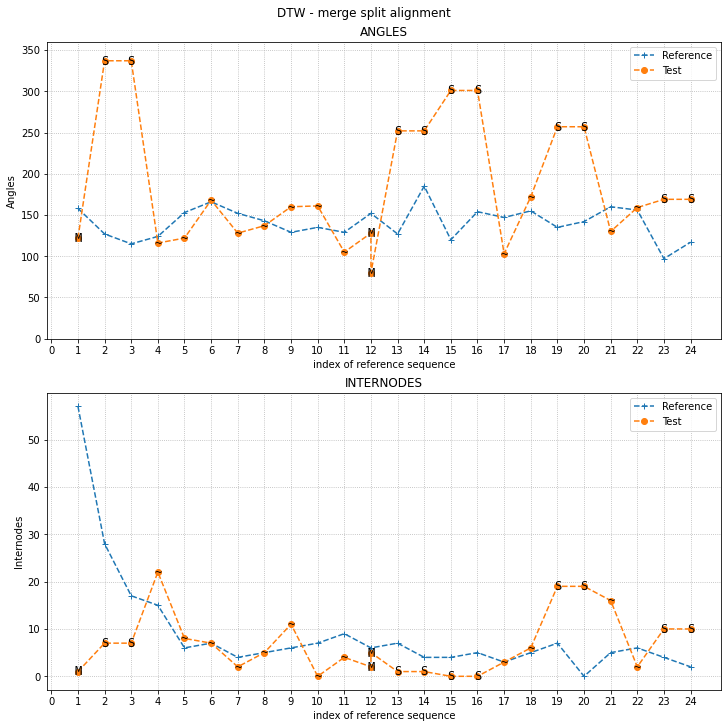

In [51]:
 dtwcomputer.plot_results(valrange=[(0, 360), None])

#Interpret the graphic:
# The reference sequence is in blue, the test sequence is in orange
# Each point of the test sequence is annotated with the code following code:
    # "~": the test point is correctly matched with the reference point, meaning that the corresponding organs forming this interval are preserved in the test sequence.
    #      the possible difference in the value between the blue and red points may come from the precision of the measure.
    # M ("Merge"): 2 test points are matched with a single reference point (so forming a vertical segment). This corresponds to an organ addition in the test sequence within the aligned reference interval.
    # S ("Split"): 1 test point is duplicated in two consecutive "S" points (forming a horizontal segment), matching two reference intervals. This corresponds to an organ loss in the test sequence

## 4. Testing manually different free-ends
Let's realign the sequence by allowing another value for free-ends. Note that this will not impose that ending intervals are trimmed, but the program will explore this possibility.

The solution may be different, but in that case, the associated normalized cost will also evolves.

In the program, free-ends are specified with a tuple of 2 integers ``(k,l)`` that specifies relaxation bounds on the alignment of sequences endpoints: relaxed by ``k`` at the sequence beginning and relaxed by ``l`` at the sequence ending. (k,l) must verify these two conditions:
        
        - ``k + l < min(N_test, N_ref)``
        - ``k >= 0`` and ``l >= 1``


In [52]:
# check the previous values of free-ends: default -and minimum value- is (0,1) for perfectly matching start and end sequences.
dtwcomputer.free_ends #check the current value

(0, 1)

[(0, 360), None]


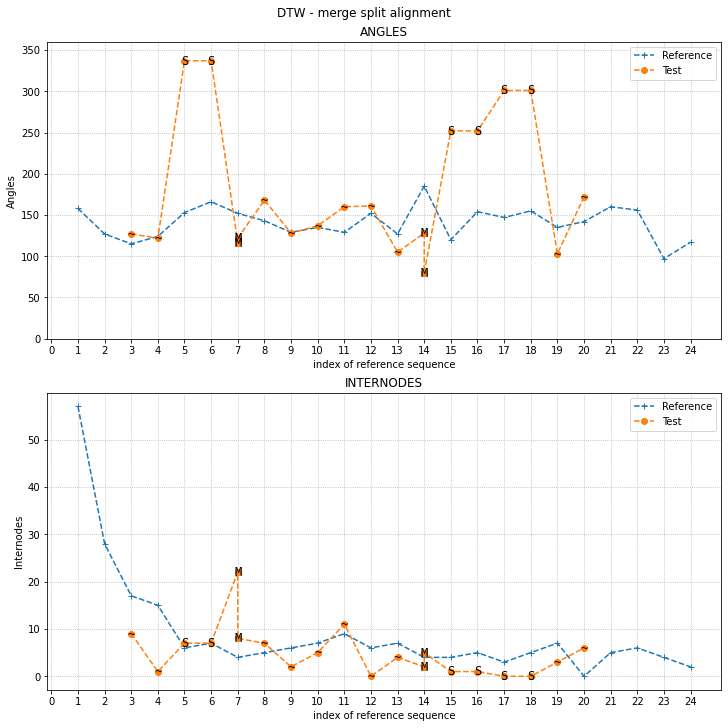

In [53]:
dtwcomputer.free_ends = (5, 5) #impose a new value
dtwcomputer.run() #up-date the alignment
dtwcomputer.plot_results(valrange=[(0, 360), None]) #up-date the plot

## 5. Automatic selection of free-ends

   - **principle**:
   
`sm-dtw` can automatize the search of an optimal free-ends size: the program will look for possible relaxation bounds at both ends and compute the normalized cost for each of them. It then **select the best free-ends solution** based on the evolution of the **normalised cost**: this one reaches a plateau after this point. 

   - **tune the sensitivity of the free-ends search**:

The main parameter to select here is `free_ends_eps`: it determines the minimum difference to previous minimum normalized cost to consider the currently tested free-ends as the new best combination (ie *"the lower, the easier to increase free-ends"*)

   - **Bound the range of free-ends search**:

Since free-ends drop parts of the sequence, there is a risk to overfit extremely short and costless alignment solutions, that would be poorly informative. To avoid this, **free-ends trimming is capped to max 40%** of the shortest sequence length among the pair to avoid. However, you can adjust the range of possible free-ends from 0% up to this 40%-cap by providing a float value x (0 <= x <= 0.4) to the `free_ends` parameter.

In [54]:
free_ends, n_cost = brute_force_free_ends_search(dtwcomputer, free_ends_eps=1, free_ends=0.3)
print(f"Found free-ends {free_ends} with a normalized distance of {n_cost}.")

Found free-ends (2, 7) with a normalized distance of 22.1665317289695.


### 5.1 Plot inspection

[(0, 360), None]


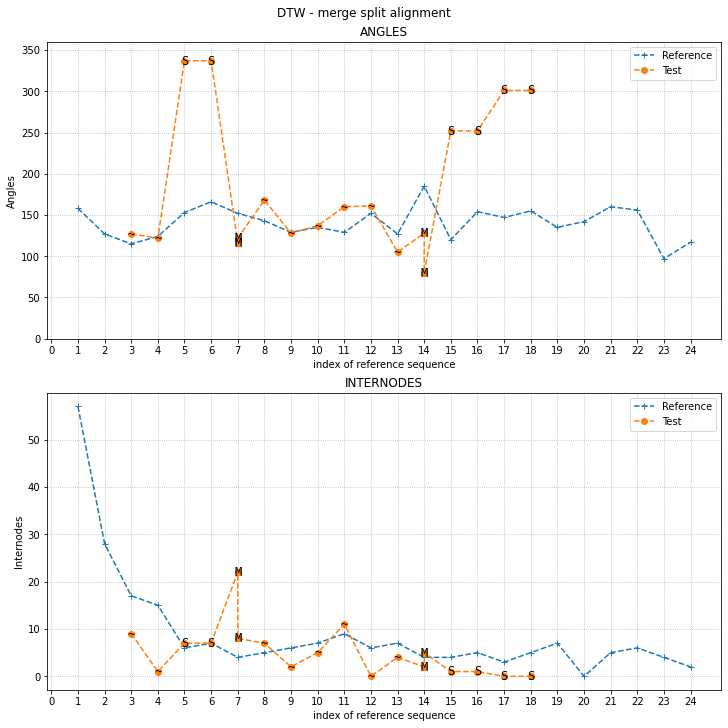

In [55]:
dtwcomputer.free_ends = free_ends #up-date free-ends value with the automatic selection
dtwcomputer.run() #re-run the alignment with the new free-ends parameter and minimal printed infos/flags
dtwcomputer.plot_results(valrange=[(0, 360), None])

## 6. Export results in a table for Step3 (assessment of sm-dtw prediction)

In [56]:
df = dtwcomputer.print_results() #store the results
# Check in the print that this last run is based on the expected parameters
# reformat the table for compatibility (later in Step3)
df.insert(loc=0, column='PlantID', value=[plant_id] * len(df.index))
df.to_csv('/myapp/docker_sandbox/smdtw_result.csv', index = False) #the result is in 'the docker_sandbox' folder as a csv file called "smdtw_result.csv"

************************************ INFOS *************************************
Test sequence length: 21
ference sequence length: 24
Type of constraints: merge_split
Beam size:  None
Free endings: (2, 7)
Mixed type: [True, False]
Mixed spread: [1, 57]
Mixed weight: [0.5, 0.5]
*********************************** RESULTS ************************************
Alignment:
test seq:  [127   9] [122   1]  -  [337   7] [116  22] [122   8] [168   7] [128   2] [137   5] [160  11] [161   0] [105   4] [128   2] [80  5]  -  [252   1]  -  [301   0] 
ref seq :  [115  17] [124  15] [153   6] [166   7]  -  [152   4] [143   5] [129   6] [135   7] [129   9] [152   6] [127   7]  -  [185   4] [120   4] [154   5] [147   3] [155   5] 
Optimal path length: 13
Optimal normalized cost: 22.1665317289695 at cell (14, 17) (non normalized: 288.1649124766035
Array of global distances (x downward, y rightward):
 [[  57.14    19.      14.422      inf      inf      inf      inf      inf
       inf      inf      inf    

In [57]:
print(df) #visualize the table that was exported

    PlantID  test  reference type       cost
0   MyPlant     0          2    ~  14.422205
1   MyPlant     1          3    ~  14.142136
2   MyPlant     2          5    s  18.973666
3   MyPlant     4          6    m  89.844310
4   MyPlant     5          7    ~  25.079872
5   MyPlant     6          8    ~   4.123106
6   MyPlant     7          9    ~   2.828427
7   MyPlant     8         10    ~  31.064449
8   MyPlant     9         11    ~  10.816654
9   MyPlant    10         12    ~  22.203603
10  MyPlant    12         13    m  23.194827
11  MyPlant    13         15    s  23.409400
12  MyPlant    14         17    s   8.062258


## End of Step2